In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [54]:
df = pd.read_csv('data/housing_adequacy_dataset.csv')
df.isnull().sum()

quarter             0
province            0
population          0
starts_saar         0
starts_saar_q       0
dwelling_starts     0
pop_change_q       11
needed_units_q     11
hai                38
dtype: int64

**Goal:** explore housing adequacy across Canadian provinces (1990–2025) and identify trends, imbalances, and drivers before forecasting housing starts.

**Key question:** how well have housing starts kept up with population growth over time?

In [55]:
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   quarter          1573 non-null   period[Q-DEC]
 1   province         1573 non-null   object       
 2   population       1573 non-null   float64      
 3   starts_saar      1573 non-null   float64      
 4   starts_saar_q    1573 non-null   float64      
 5   dwelling_starts  1573 non-null   float64      
 6   pop_change_q     1562 non-null   float64      
 7   needed_units_q   1562 non-null   float64      
 8   hai              1535 non-null   float64      
dtypes: float64(7), object(1), period[Q-DEC](1)
memory usage: 110.7+ KB


In [56]:
df.describe().T
df.groupby('province')[['starts_saar_q', 'pop_change_q', 'hai']].agg(['mean', 'std', 'min', 'max'])

starts_saar_q                                   pop_change_q  \
                  mean        std        min        max          mean   
province                                                                
ab            7.492707   2.711059   2.123667  16.340583  17671.056338   
bc            8.311432   2.660771   3.118250  14.153917  17254.345070   
can          48.675700  10.570117  26.416417  72.671250  99916.218310   
mb            1.248358   0.537222   0.337417   2.604833   2865.845070   
nb            0.864115   0.329610   0.307167   2.198375    932.218310   
nl            0.545119   0.239286   0.121333   1.471917   -185.683099   
ns            1.188508   0.398549   0.483167   3.163500   1308.809859   
on           17.154016   4.102838   8.285333  27.755167  42734.330986   
pe            0.204024   0.085831   0.055833   0.663250    368.457746   
qc           10.655562   3.075776   4.922250  21.318500  14811.112676   
sk            1.011860   0.549048   0.213000   2.796833   1799.507042   

                                               hai                         \
                   std     min       max      mean        std         min   
province                                                                    
ab        10522.225759  2040.0   63597.0  1.275507   0.749751    0.416939   
bc        11033.293383 -2205.0   57398.0  0.546676   9.861257 -112.139771   
can       63843.201281 -1232.0  418634.0  0.744219  10.525314 -123.080188   
mb         2437.190015  -479.0   11292.0  1.599952   1.725052   -4.800858   
nb         1788.577763  -889.0    9027.0  4.028840  18.653596  -98.966346   
nl         1206.466633 -3290.0    2551.0  0.177645   7.806022  -43.643293   
ns         2364.492703 -2062.0   10683.0  1.500149  14.406792 -107.658046   
on        29632.220151 -4229.0  191475.0  1.908097   4.730203  -12.252601   
pe          540.668586  -355.0    2439.0  1.210127   4.637295  -19.076577   
qc        11024.520698 -2455.0   60805.0  3.012454  19.879612 -109.574319   
sk         2770.048193 -3513.0   11895.0  0.505780   5.668734  -52.198465   

                      
                 max  
province              
ab          7.238051  
bc         12.617765  
can         6.975010  
mb         11.188017  
nb        112.644231  
nl         42.039931  
ns         58.841324  
on         43.384151  
pe         15.808333  
qc        194.716880  
sk         23.627137

In [57]:
df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai
0,1990Q1,can,27463550.0,262.338000,65.584500,65584.500000,NaN,NaN,NaN
1,1990Q1,nl,576278.0,5.887667,1.471917,1471.916667,NaN,NaN,NaN
2,1990Q1,pe,130336.0,1.098333,0.274583,274.583333,NaN,NaN,NaN
3,1990Q1,ns,907394.0,5.427667,1.356917,1356.916667,NaN,NaN,NaN
4,1990Q1,nb,737307.0,4.969000,1.242250,1242.250000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1568,2025Q3,on,16258260.0,68.557500,17.139375,17139.375000,1722.0,688.8,24.882949
1569,2025Q3,mb,1509702.0,7.775500,1.943875,1943.875000,1671.0,668.4,2.908251
1570,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578
1571,2025Q3,ab,5029346.0,49.756500,12.439125,12439.125000,19268.0,7707.2,1.613962


In [58]:
df["year"] = df["quarter"].apply(lambda q: q.year)
data = df.groupby(["province","year"])[["starts_saar_q","hai"]].mean().reset_index()

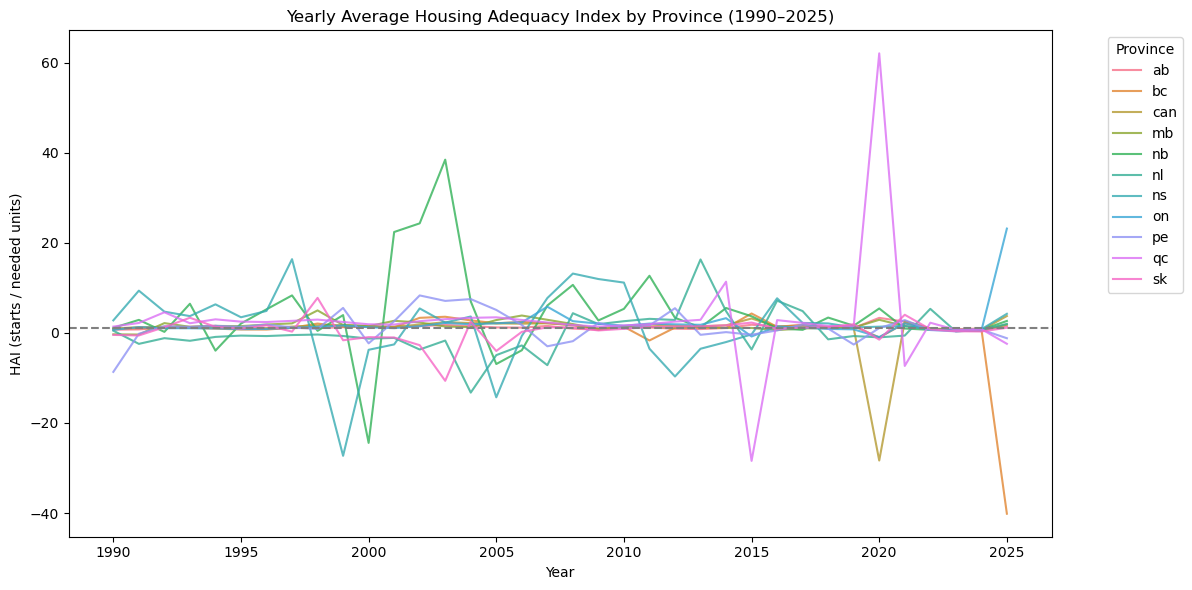

In [59]:
plt.figure(figsize=(12,6))
sns.lineplot(data, x="year", y="hai", hue="province", alpha=0.8)
plt.axhline(1, color="gray", ls="--")
plt.title("Yearly Average Housing Adequacy Index by Province (1990–2025)")
plt.ylabel("HAI (starts / needed units)")
plt.xlabel("Year")
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [60]:
df[["starts_saar_q", "needed_units_q", "hai"]].describe().T


,count,mean,std,min,25%,50%,75%,max
starts_saar_q,1573.0,8.850127,14.140696,0.055833,0.710583,1.621667,10.799250,72.67125
needed_units_q,1562.0,7253.680666,14442.098676,-1691.600000,137.800000,1531.000000,7567.600000,167453.60000
hai,1535.0,1.504185,10.932435,-123.080188,0.672026,1.182914,2.075488,194.71688


<Axes: xlabel='province', ylabel='quarter'>

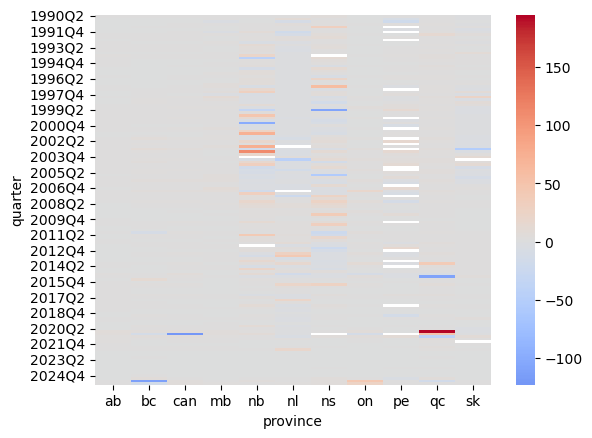

In [61]:
sns.heatmap(
    df.pivot_table(values="hai", index="quarter", columns="province"),
    cmap="coolwarm", center=1  # or center=0 to highlight surpluses vs shortages
)


In [62]:
df["starts_saar_q_dwellings"] = df["starts_saar_q"] * 1000
df["hai"] = df["starts_saar_q_dwellings"] / df["needed_units_q"]


In [63]:
df

,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,year,starts_saar_q_dwellings
0,1990Q1,can,27463550.0,262.338000,65.584500,65584.500000,NaN,NaN,NaN,1990,65584.500000
1,1990Q1,nl,576278.0,5.887667,1.471917,1471.916667,NaN,NaN,NaN,1990,1471.916667
2,1990Q1,pe,130336.0,1.098333,0.274583,274.583333,NaN,NaN,NaN,1990,274.583333
3,1990Q1,ns,907394.0,5.427667,1.356917,1356.916667,NaN,NaN,NaN,1990,1356.916667
4,1990Q1,nb,737307.0,4.969000,1.242250,1242.250000,NaN,NaN,NaN,1990,1242.250000
...,...,...,...,...,...,...,...,...,...,...,...
1568,2025Q3,on,16258260.0,68.557500,17.139375,17139.375000,1722.0,688.8,24.882949,2025,17139.375000
1569,2025Q3,mb,1509702.0,7.775500,1.943875,1943.875000,1671.0,668.4,2.908251,2025,1943.875000
1570,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578,2025,1252.250000
1571,2025Q3,ab,5029346.0,49.756500,12.439125,12439.125000,19268.0,7707.2,1.613962,2025,12439.125000


In [64]:
print(df.describe())
print(df.isna().sum())
print(df.corr(numeric_only=True))

         population  starts_saar  starts_saar_q  dwelling_starts  \
count  1.573000e+03  1573.000000    1573.000000      1573.000000   
mean   6.067748e+06    35.400509       8.850127      8850.127252   
std    9.503270e+06    56.562784      14.140696     14140.696050   
min    1.303360e+05     0.223333       0.055833        55.833333   
25%    7.646120e+05     2.842333       0.710583       710.583333   
50%    1.211881e+06     6.486667       1.621667      1621.666667   
75%    7.305302e+06    43.197000      10.799250     10799.250000   
max    4.165165e+07   290.685000      72.671250     72671.250000   

        pop_change_q  needed_units_q          hai         year  \
count    1562.000000     1562.000000  1562.000000  1573.000000   
mean    18134.201665     7253.680666          inf  2007.377622   
std     36105.246691    14442.098676          NaN    10.323880   
min     -4229.000000    -1691.600000  -257.857143  1990.000000   
25%       344.500000      137.800000     0.661090  1998.0

/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


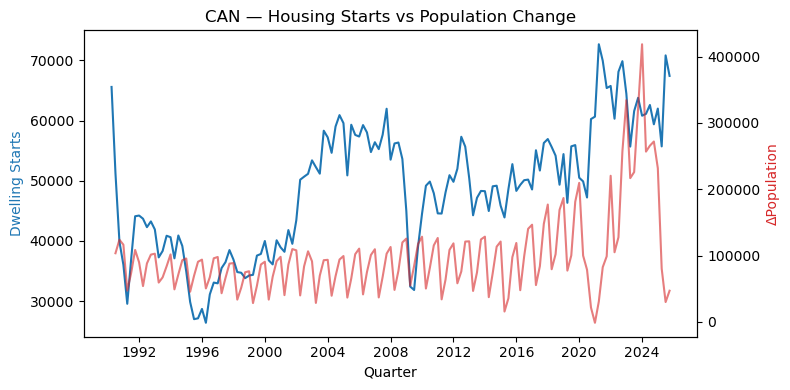

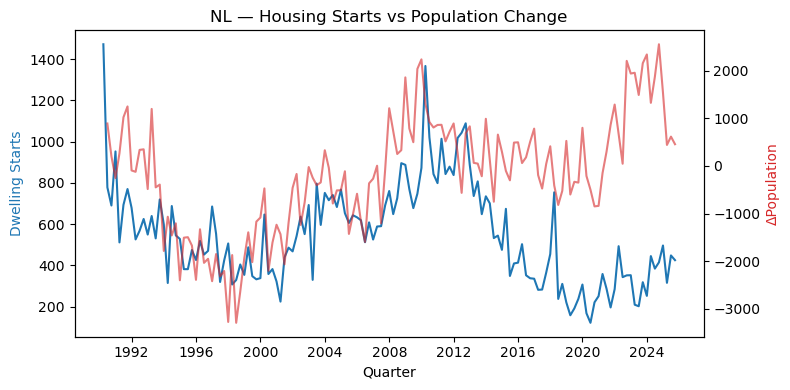

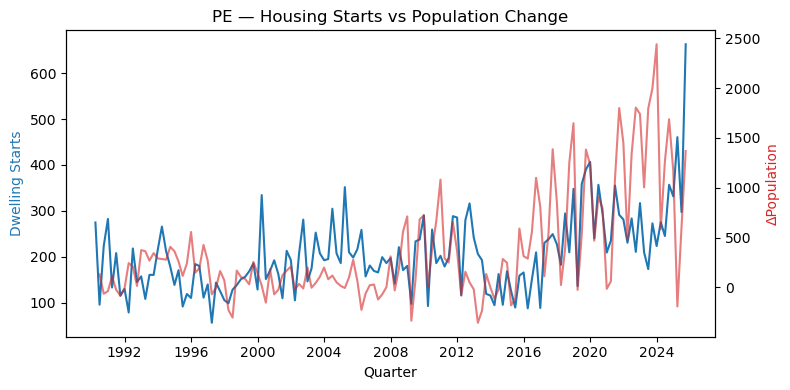

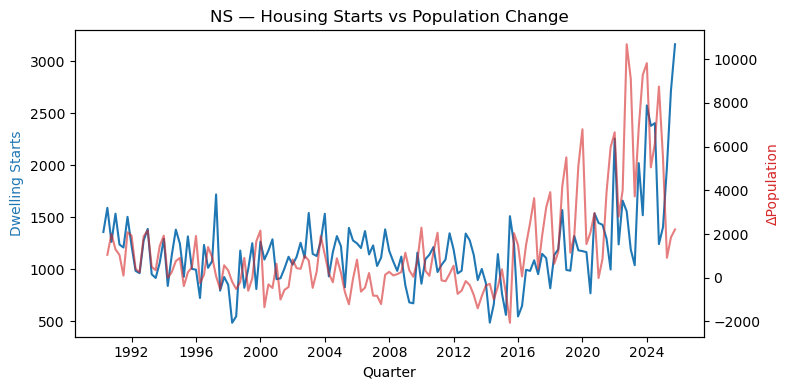

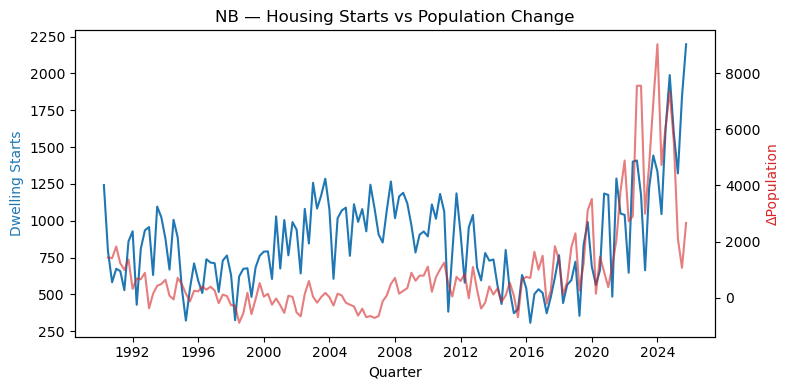

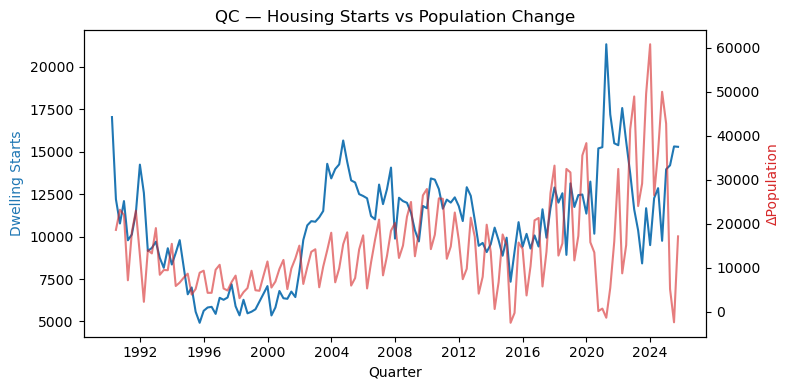

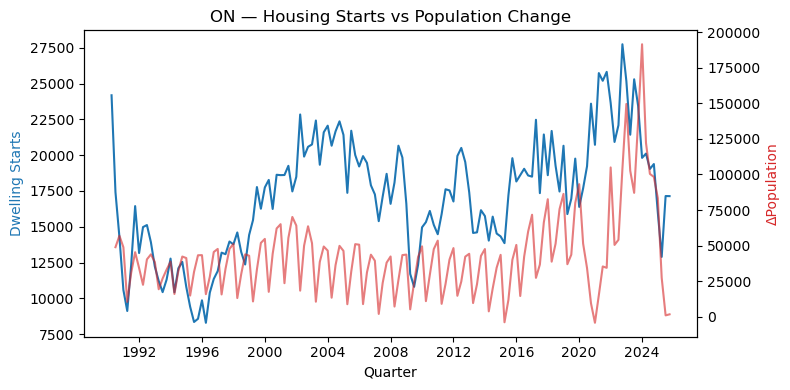

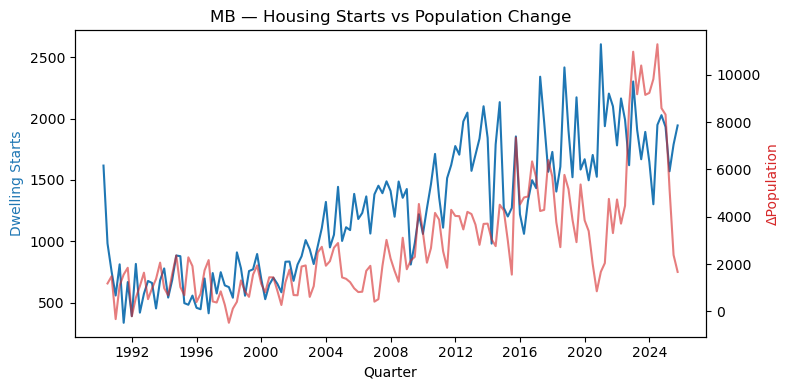

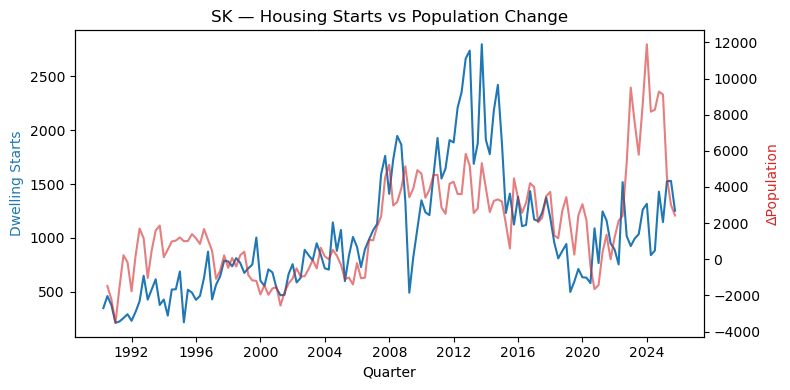

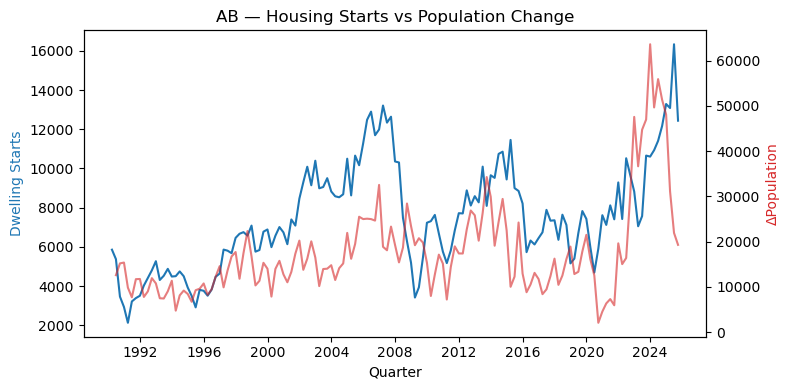

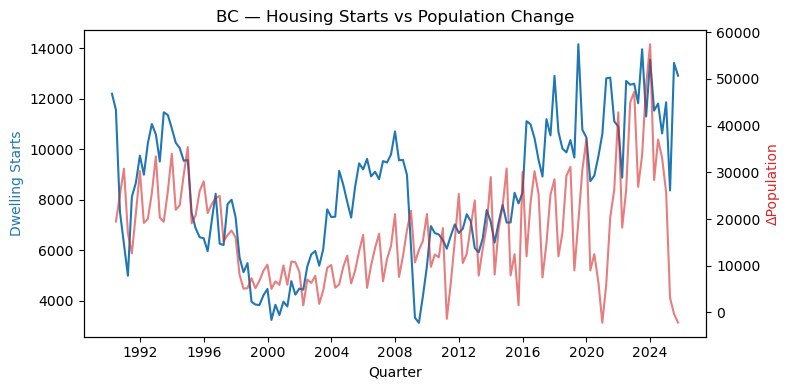

In [65]:
provinces = df["province"].unique()
df['q_dt'] = df['quarter'].dt.to_timestamp('Q')
for p in provinces:
    sub = df[df["province"] == p]
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twinx()
    ax1.plot(sub["q_dt"], sub["dwelling_starts"], color="tab:blue", label="Housing Starts")
    ax2.plot(sub["q_dt"], sub["pop_change_q"], color="tab:red", alpha=0.6, label="ΔPopulation")

    ax1.set_title(f"{p.upper()} — Housing Starts vs Population Change")
    ax1.set_xlabel("Quarter")
    ax1.set_ylabel("Dwelling Starts", color="tab:blue")
    ax2.set_ylabel("ΔPopulation", color="tab:red")
    plt.tight_layout()
    plt.show()

In [68]:
df["starts_per_1k_newpop"] = df["dwelling_starts"] / (df["pop_change_q"] / 1000)
df.groupby('province')['starts_saar_q_dwellings'].describe()

,count,mean,std,min,25%,50%,75%,max
province,,,,,,,,
ab,143.0,7492.706585,2711.059083,2123.666667,5703.166667,7230.750000,9215.250000,16340.583333
bc,143.0,8311.432401,2660.771203,3118.250000,6344.541667,8279.666667,10393.458333,14153.916667
can,143.0,48675.699883,10570.117043,26416.416667,39954.625000,49347.250000,56312.916667,72671.250000
mb,143.0,1248.358100,537.222012,337.416667,776.541667,1231.500000,1658.041667,2604.833333
nb,143.0,864.114510,329.610065,307.166667,627.083333,801.500000,1069.500000,2198.375000
nl,143.0,545.118881,239.286123,121.333333,351.541667,525.000000,691.583333,1471.916667
ns,143.0,1188.508159,398.549141,483.166667,982.833333,1144.416667,1289.458333,3163.500000
on,143.0,17154.016026,4102.837613,8285.333333,14374.958333,17408.166667,19870.833333,27755.166667
pe,143.0,204.023893,85.831403,55.833333,145.458333,192.333333,243.333333,663.250000


## Line plots (for comparison) of Housing Starts and Units Needed for each province in each quarter from 1990-2025

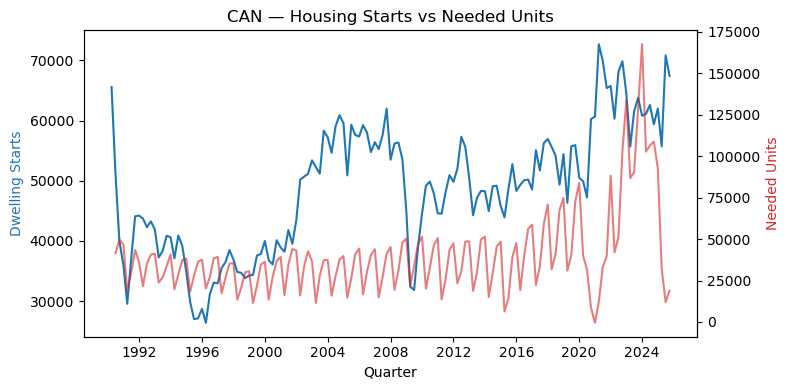

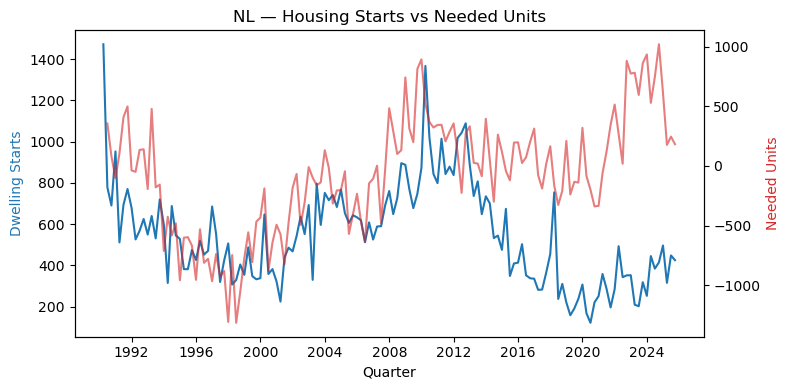

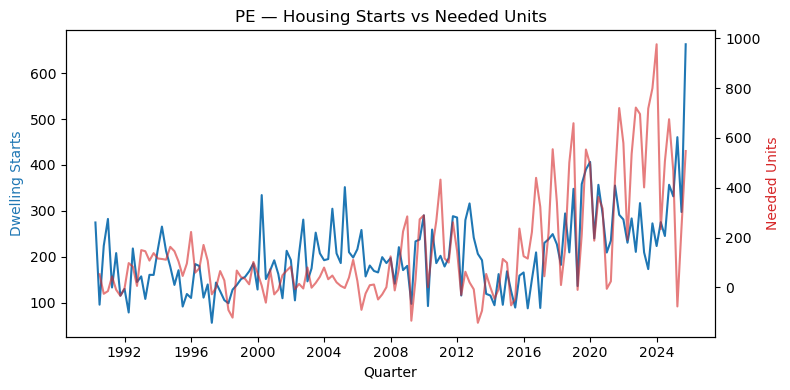

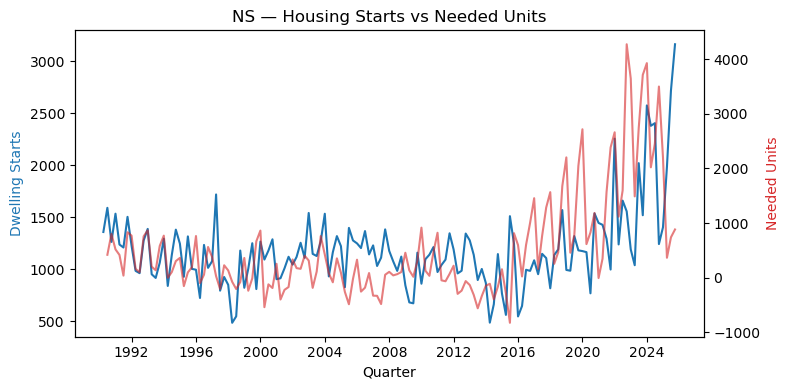

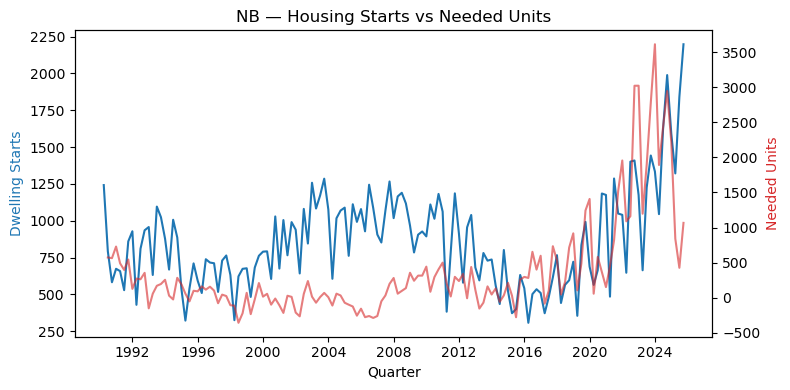

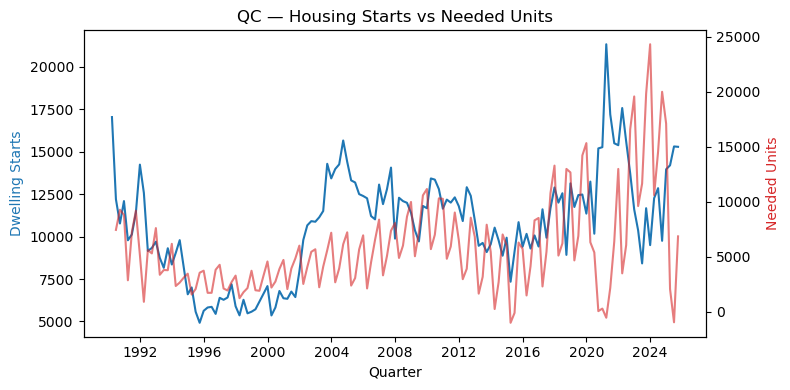

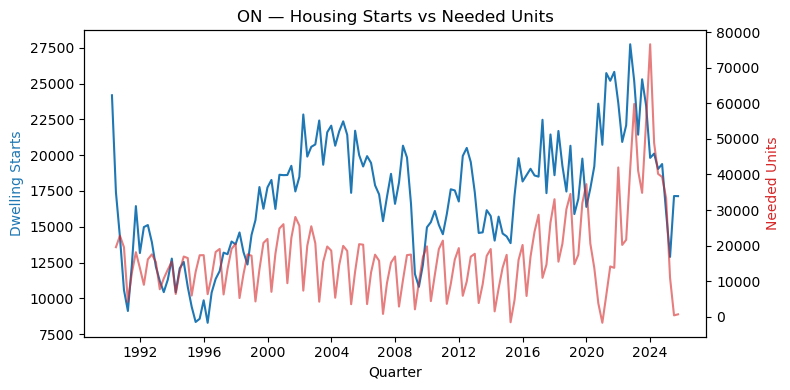

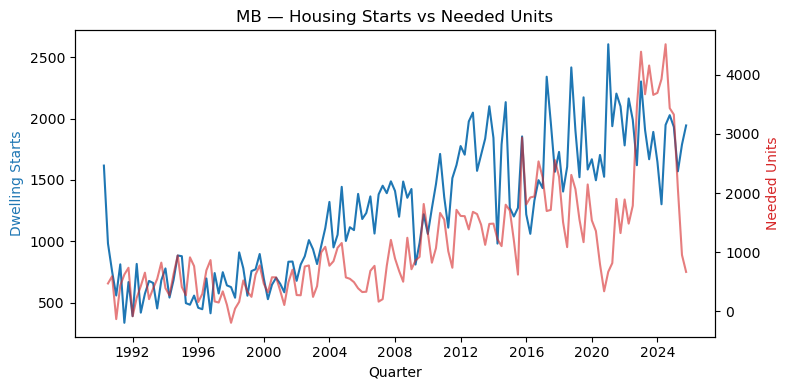

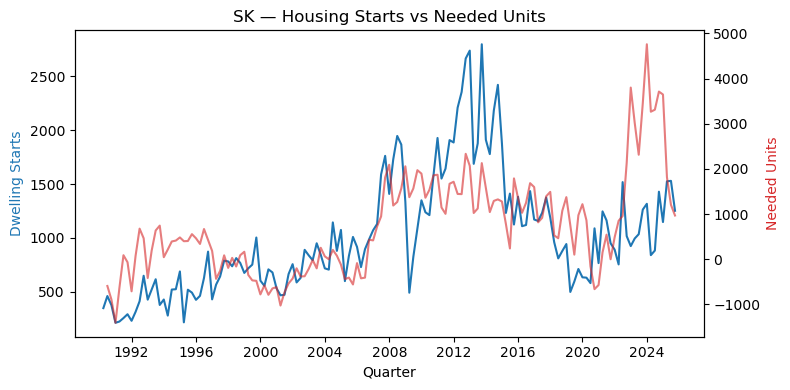

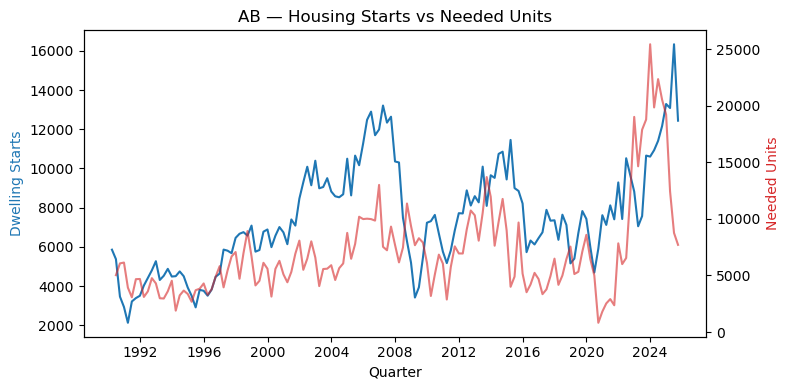

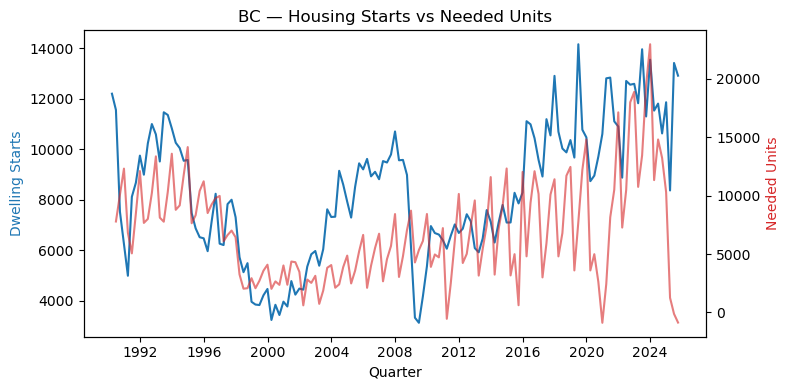

In [69]:
for p in provinces:
    sub = df[df["province"] == p]
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twinx()
    ax1.plot(sub["q_dt"], sub["dwelling_starts"], color="tab:blue", label="Housing Starts")
    ax2.plot(sub["q_dt"], sub["needed_units_q"], color="tab:red", alpha=0.6, label="Needed Units")

    ax1.set_title(f"{p.upper()} — Housing Starts vs Needed Units")
    ax1.set_xlabel("Quarter")
    ax1.set_ylabel("Dwelling Starts", color="tab:blue")
    ax2.set_ylabel("Needed Units", color="tab:red")
    plt.tight_layout()
    plt.show()

## ACF/PACF

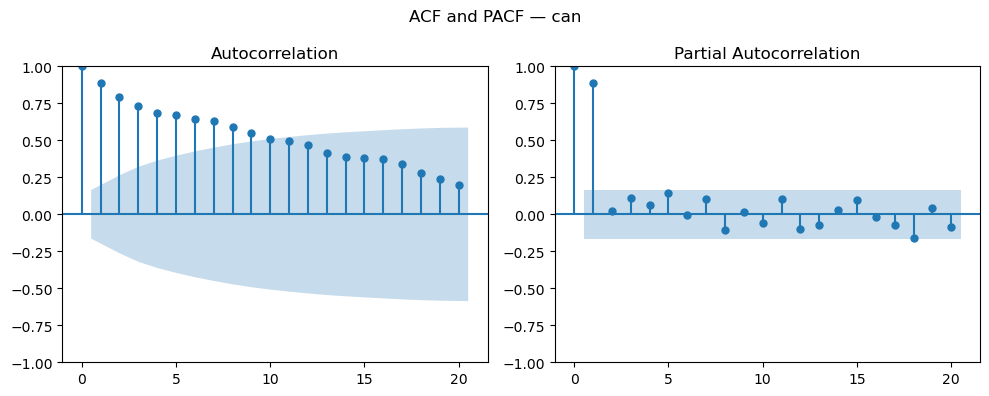

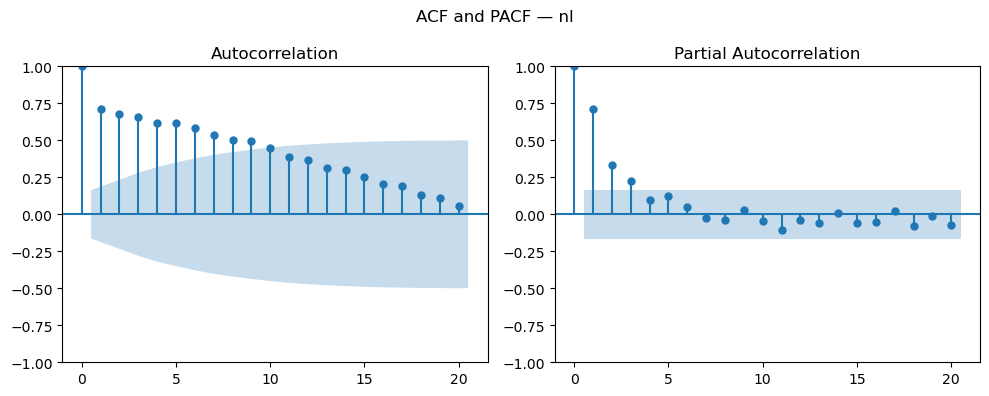

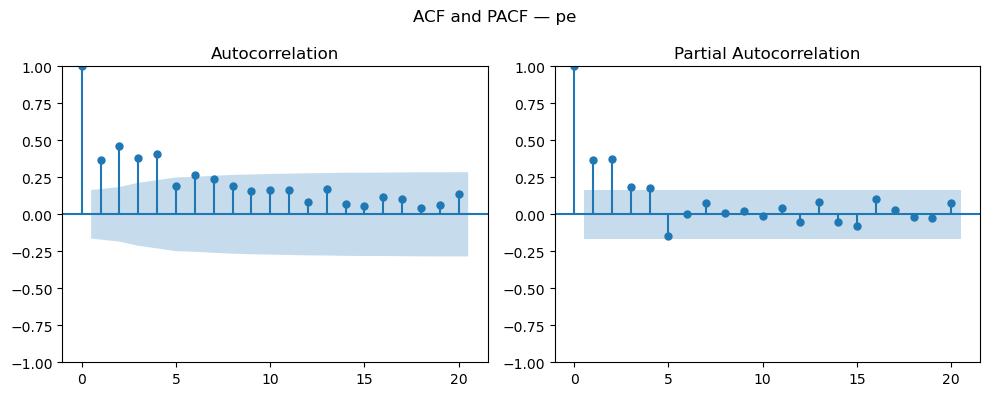

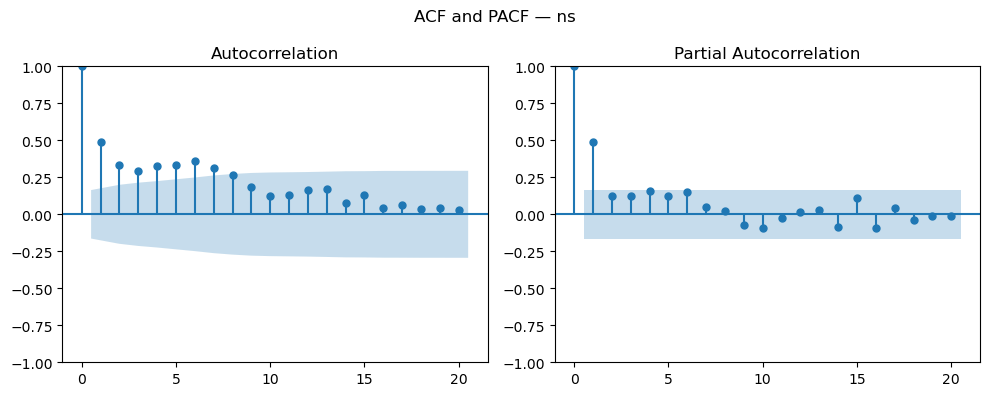

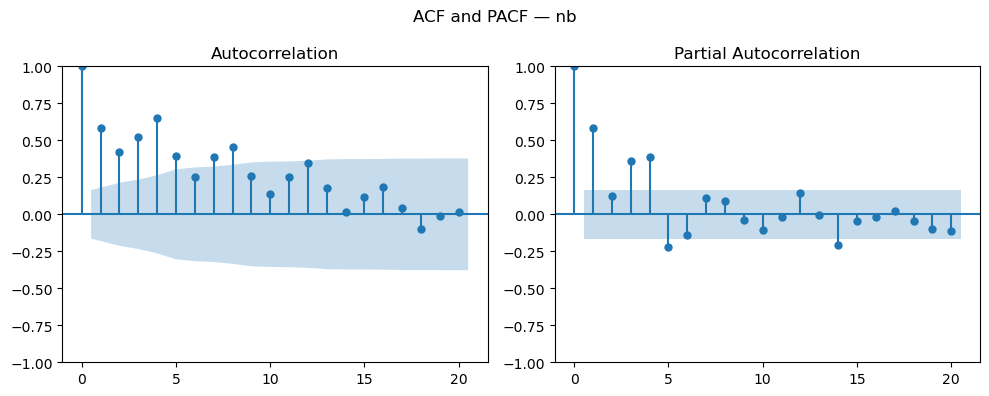

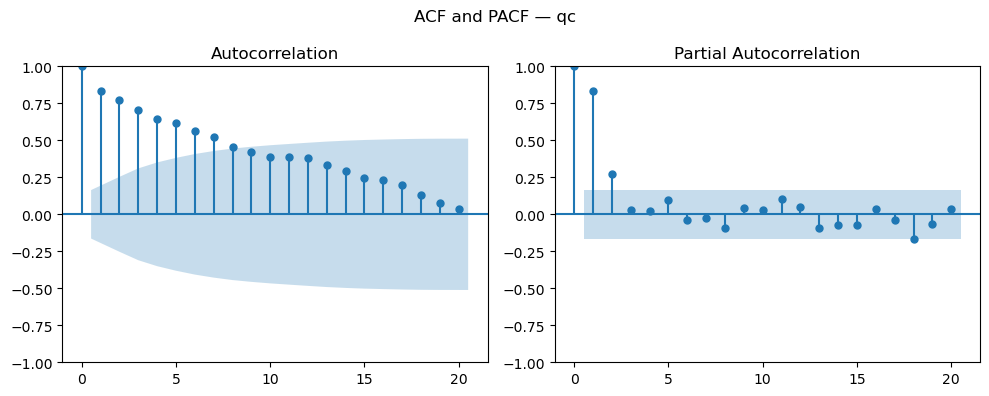

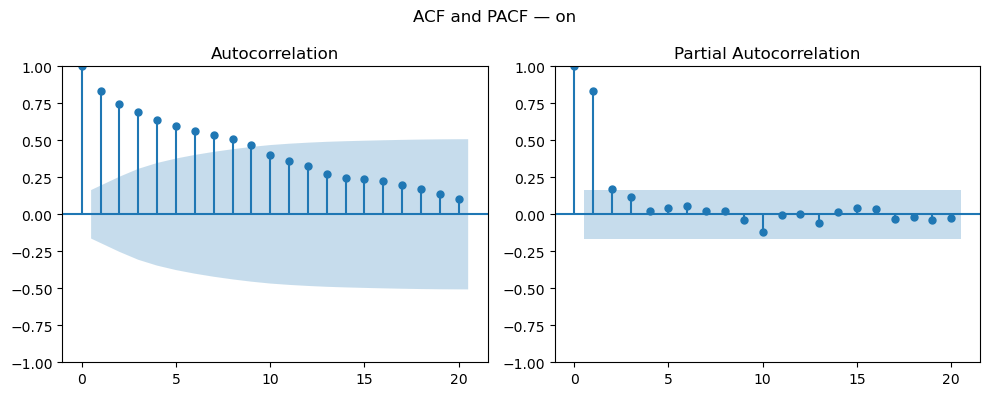

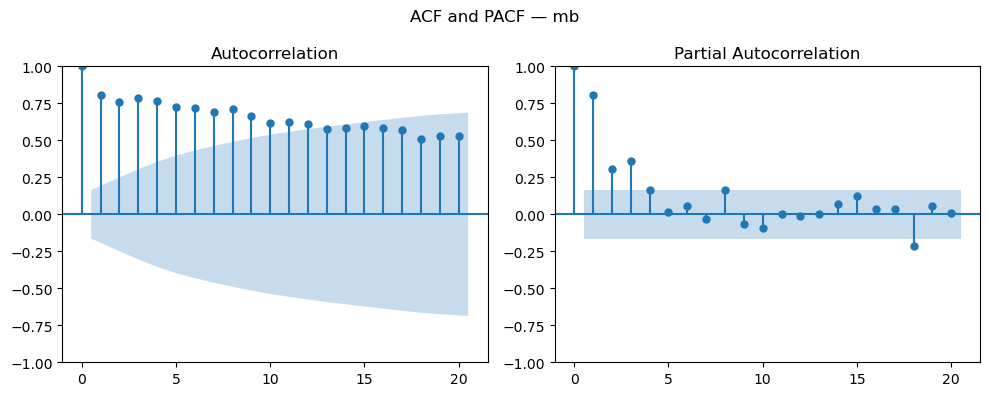

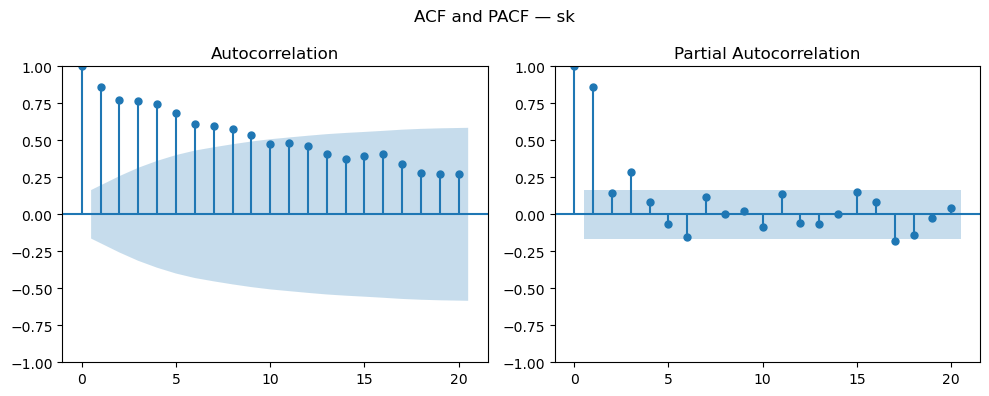

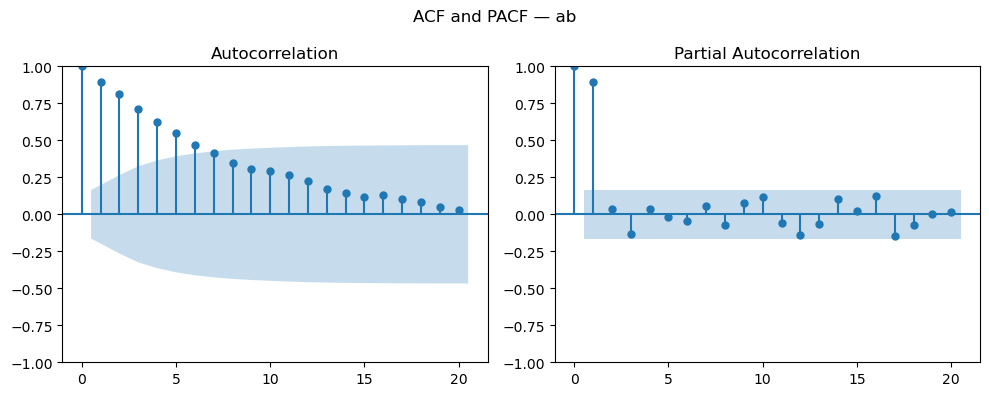

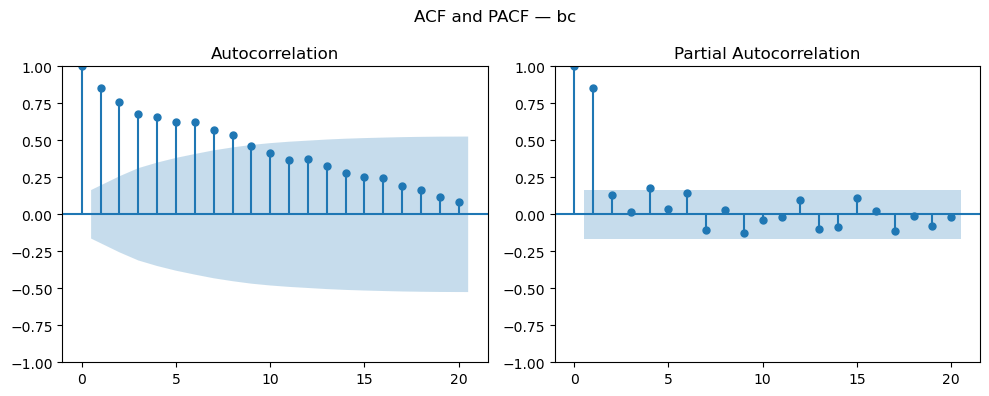

In [72]:
for p in provinces:
    ts = (df[df['province']==p]
          .set_index('quarter')['dwelling_starts']
          .dropna())

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    plot_acf(ts, lags=20, ax=axes[0])
    plot_pacf(ts, lags=20, ax=axes[1], method='ywm')
    fig.suptitle(f'ACF and PACF — {p}', fontsize=12)
    plt.tight_layout()
    plt.show()

### AD Fuller Test to test stationarity

In [75]:
results = []

for p in df['province'].unique():
    ts = (df[df['province']==p]
          .set_index('quarter')['dwelling_starts']
          .dropna())

    adf = adfuller(ts)
    results.append({
        'province': p,
        'ADF Statistic': adf[0],
        'p-value': adf[1],
        'lags used': adf[2],
        'obs': adf[3]
    })

adf_results = pd.DataFrame(results)
print(adf_results.sort_values('p-value'))

   province  ADF Statistic   p-value  lags used  obs
0       can      -2.584160  0.096315          0  142
6        on      -2.404003  0.140610          2  140
1        nl      -2.285979  0.176530          3  139
9        ab      -2.239009  0.192393          2  140
5        qc      -2.232828  0.194547          1  141
8        sk      -1.992974  0.289662          2  140
10       bc      -1.494956  0.536005          8  134
7        mb      -1.211784  0.668506          3  139
2        pe      -0.902900  0.787016          4  138
4        nb      -0.657279  0.857507         13  129
3        ns       1.902898  0.998533          7  135


All the p-values are >0.05 which is in line with our assumption that the series is non-stationary and we will need 1st order differencing.

In [76]:
summary = []

for p in df['province'].unique():
    ts = (df[df['province']==p]
          .set_index('quarter')['dwelling_starts']
          .dropna())
    
    # ADF before differencing
    adf_orig = adfuller(ts)
    
    # ADF after first differencing
    adf_diff = adfuller(ts.diff().dropna())
    
    summary.append({
        'province': p,
        'ADF stat (orig)': adf_orig[0],
        'p (orig)': adf_orig[1],
        'ADF stat (diff)': adf_diff[0],
        'p (diff)': adf_diff[1],
        'stationary_before': adf_orig[1] < 0.05,
        'stationary_after': adf_diff[1] < 0.05
    })

adf_summary = pd.DataFrame(summary)
print(adf_summary.sort_values('p (orig)'))

   province  ADF stat (orig)  p (orig)  ADF stat (diff)      p (diff)  \
0       can        -2.584160  0.096315       -12.631391  1.502151e-23   
6        on        -2.404003  0.140610       -10.824739  1.768658e-19   
1        nl        -2.285979  0.176530        -9.105220  3.517495e-15   
9        ab        -2.239009  0.192393        -7.919205  3.763805e-12   
5        qc        -2.232828  0.194547       -16.745092  1.348264e-29   
8        sk        -1.992974  0.289662        -9.849349  4.529251e-17   
10       bc        -1.494956  0.536005        -3.571356  6.332851e-03   
7        mb        -1.211784  0.668506        -7.137375  3.393393e-10   
2        pe        -0.902900  0.787016        -6.627321  5.831952e-09   
4        nb        -0.657279  0.857507        -1.769303  3.958046e-01   
3        ns         1.902898  0.998533        -7.414431  6.995712e-11   

    stationary_before  stationary_after  
0               False              True  
6               False              True

For d=1, other than for NB, all the other series becomes stationary.

### Correlation between Housing starts and Units needed

In [78]:
corrs = []

for p in provinces:
    temp = df[df['province']==p].dropna(subset=['dwelling_starts','needed_units_q','pop_change_q'])
    pearson = temp['dwelling_starts'].corr(temp['needed_units_q'])
    spearman = temp['dwelling_starts'].corr(temp['needed_units_q'], method='spearman')
    corr_pop = temp['dwelling_starts'].corr(temp['pop_change_q'])
    
    corrs.append({'province': p,
                  'corr_starts_needed (Pearson)': pearson,
                  'corr_starts_needed (Spearman)': spearman,
                  'corr_starts_popchange': corr_pop})

corr_df = pd.DataFrame(corrs).sort_values('corr_starts_needed (Pearson)', ascending=False)
print(corr_df)

   province  corr_starts_needed (Pearson)  corr_starts_needed (Spearman)  \
7        mb                      0.634941                       0.727726   
9        ab                      0.556044                       0.630534   
8        sk                      0.548479                       0.657492   
10       bc                      0.480834                       0.473804   
4        nb                      0.457127                       0.202184   
2        pe                      0.449573                       0.400613   
3        ns                      0.420854                       0.342138   
0       can                      0.362263                       0.285481   
6        on                      0.340188                       0.288719   
5        qc                      0.218997                       0.323188   
1        nl                      0.213076                       0.220979   

    corr_starts_popchange  
7                0.634941  
9                0.556044  
8  

### Lag Correlations

In [79]:
lag_corrs = []

for p in df['province'].unique():
    temp = df[df['province']==p].dropna(subset=['dwelling_starts','needed_units_q'])
    starts = temp['dwelling_starts']
    needed = temp['needed_units_q']
    
    corr_0 = starts.corr(needed)                        # same quarter
    corr_1 = starts.corr(needed.shift(1))               # 1 quarter lag
    corr_2 = starts.corr(needed.shift(2))               # 2 quarter lag
    
    lag_corrs.append({
        'province': p,
        'corr_lag0': corr_0,
        'corr_lag1': corr_1,
        'corr_lag2': corr_2
    })

lag_corr_df = pd.DataFrame(lag_corrs)
print(lag_corr_df.sort_values('corr_lag0', ascending=False))

   province  corr_lag0  corr_lag1  corr_lag2
7        mb   0.634941   0.586803   0.578159
9        ab   0.556044   0.569580   0.612919
8        sk   0.548479   0.507503   0.489894
10       bc   0.480834   0.359400   0.403964
4        nb   0.457127   0.327058   0.366849
2        pe   0.449573   0.308364   0.270963
3        ns   0.420854   0.357517   0.472811
0       can   0.362263   0.258696   0.283030
6        on   0.340188   0.224196   0.194987
5        qc   0.218997   0.253450   0.274679
1        nl   0.213076   0.229926   0.234451


In [80]:
stats = (df.groupby('province')['dwelling_starts']
           .agg(['mean','std','min','max','count'])
           .assign(var=lambda x: x['std']**2)
           .sort_values('mean', ascending=False))

print(stats)

                  mean           std           min           max  count  \
province                                                                  
can       48675.699883  10570.117043  26416.416667  72671.250000    143   
on        17154.016026   4102.837613   8285.333333  27755.166667    143   
qc        10655.561772   3075.775972   4922.250000  21318.500000    143   
bc         8311.432401   2660.771203   3118.250000  14153.916667    143   
ab         7492.706585   2711.059083   2123.666667  16340.583333    143   
mb         1248.358100    537.222012    337.416667   2604.833333    143   
ns         1188.508159    398.549141    483.166667   3163.500000    143   
sk         1011.859557    549.047545    213.000000   2796.833333    143   
nb          864.114510    329.610065    307.166667   2198.375000    143   
nl          545.118881    239.286123    121.333333   1471.916667    143   
pe          204.023893     85.831403     55.833333    663.250000    143   

                   var  

<Axes: title={'center': 'Province-wise Mean & Std of Dwelling Starts'}, xlabel='province'>

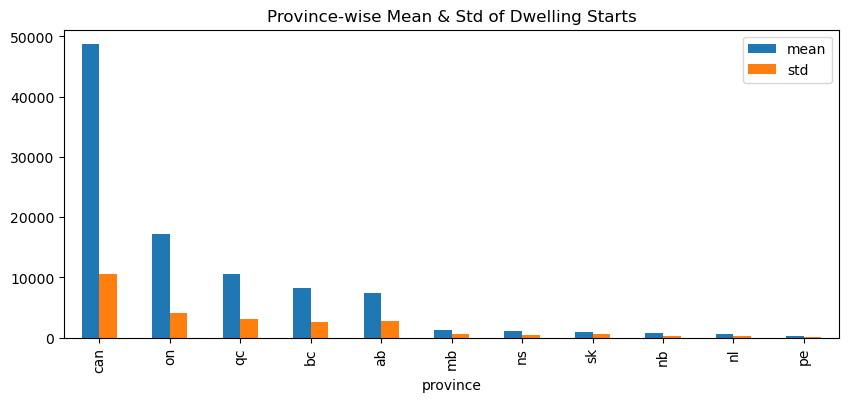

In [81]:
stats[['mean','std']].plot(kind='bar', figsize=(10,4), title='Province-wise Mean & Std of Dwelling Starts')